In [1]:
import pandas as pd
import glob

import matplotlib.pyplot as plt

In [2]:
path = './results_v3'
data = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))

In [3]:
data.head()

,Unnamed: 0,dataset_name,model_name,x_type,edge_type,mean_test_accuracy,test_accuracies,num_epochs,model_params,noise_info,repeat_num,choose_type,bidirectional,k_nodes,noise_level
0,0,Cora,GNN,x,edge_removal_nodes_choose_type-bottom_k_bidire...,0.793,"0.785,0.806,0.789",25,"{'in_channels': 1433, 'hidden_channels': 30, '...","{'noise_type': 'edge_removal', 'strategy': 'no...",3,bottom,True,135.0,0.00
1,1,Cora,GNN,x,edge_removal_nodes_choose_type-bottom_k_bidire...,0.791,"0.785,0.789,0.798",25,"{'in_channels': 1433, 'hidden_channels': 30, '...","{'noise_type': 'edge_removal', 'strategy': 'no...",3,bottom,True,135.0,0.01
2,2,Cora,GNN,x,edge_removal_nodes_choose_type-bottom_k_bidire...,0.789,"0.784,0.79,0.794",25,"{'in_channels': 1433, 'hidden_channels': 30, '...","{'noise_type': 'edge_removal', 'strategy': 'no...",3,bottom,True,135.0,0.05
3,3,Cora,GNN,x,edge_removal_nodes_choose_type-bottom_k_bidire...,0.799,"0.799,0.796,0.803",25,"{'in_channels': 1433, 'hidden_channels': 30, '...","{'noise_type': 'edge_removal', 'strategy': 'no...",3,bottom,True,135.0,0.10
4,4,Cora,GNN,x,edge_removal_nodes_choose_type-bottom_k_bidire...,0.794,"0.804,0.791,0.787",25,"{'in_channels': 1433, 'hidden_channels': 30, '...","{'noise_type': 'edge_removal', 'strategy': 'no...",3,bottom,True,135.0,0.15


In [4]:
## Visualization 1
import regex as re

def get_noise_type(noise_info: str):
    val = noise_info.split(',')[0]
    noise_type = val.split(':')[1]
    noise_type = noise_type.replace("'", '')
    noise_type = noise_type.rstrip()
    noise_type = noise_type.lstrip()
    return noise_type

def get_noise_strategy(noise_info: str):
    val = noise_info.split(',')[1]
    strategy = val.split(':')[1]
    strategy = strategy.replace("'", '')
    strategy = strategy.rstrip()
    strategy = strategy.lstrip()
    return strategy

def get_choose_k(noise_info: str):
    
    try:
        ind = noise_info.rindex("choose_type")
        new_str = noise_info[ind: ]
        val = new_str.split(',')[1]
        choose_k = val.split(':')[1]
        choose_k = choose_k.replace("'", '')
        choose_k = choose_k.rstrip()
        choose_k = choose_k.lstrip()
    except:
        choose_k = "Not_Available"
    return choose_k

def get_noiseLvl1 (x_type: str):
    try:
        ind = x_type.rindex("noiselvl")
        new_str = x_type[ind: ]
        val = new_str.split('-')[1]
        val = val.rstrip()
        val = val.lstrip()
    except:
        val = 0
#     print(val)
    return float(val)

def get_noiseLvl1_from_edge (edge_type: str):
    try:
        ind = edge_type.rindex("noiselvl")
        new_str = edge_type[ind: ]
        val = new_str.split('-')[1]
        val = val.rstrip()
        val = val.lstrip()
    except:
        val = 0
#     print(val)
    return float(val)

In [6]:
data['noise_type'] = data['noise_info'].apply(lambda x: get_noise_type(x))
data['noise_strategy'] = data['noise_info'].apply(lambda x: get_noise_strategy(x))
data['choose_k'] = data['noise_info'].apply(lambda x: get_choose_k(x))
data['x_type_noiseLvl'] = data['x_type'].apply(lambda x: get_noiseLvl1(x))
data['edge_type_noiseLvl'] = data['edge_type'].apply(lambda x: get_noiseLvl1_from_edge(x))

## For some reason for the same 'choose_type' there are 3 'choose_k'

data['noise_level'] = data['noise_level'].fillna(data['x_type_noiseLvl'])
data['noise_level'] = data.apply(lambda row: row['edge_type_noiseLvl'] if row['noise_strategy'] == 'all_edges' \
                                else row['noise_level'], axis = 1)


In [7]:
# parameters
noise_levels = [0, 0.01, 0.05, 0.1, 0.15, 0.3, 0.45, 0.6, 0.9, 0.95, 0.99, 1 ]
choose_type = ['random', 'top', 'bottom']
graph_models = ['GNN', 'GAT', 'Graphsage']
noise_type = ['feature_noise', 'edge_removal', 'edge_addition']
strategy_type = ['all_edges', 'nodes'] # for edge_removal and edge addition
# for edge removal - strategy is all edges or nodes
k_nodes = list(set(data[(data['noise_type'] == 'edge_removal') & (data['noise_strategy'] == 'nodes')]['k_nodes']))

In [23]:
def plot_comparison(data: pd.DataFrame(), noise_type = 'feature_noise', strategy_type = 'all_edges', \
                   choose_type = 'random'):
    
    if(noise_type == 'feature_noise'):
        acc = []
        noise_lvl = []
        models = []
        tmp = data[data['noise_type'] == noise_type]
        for model in graph_models:
            tmp2 = tmp[tmp['model_name'] == model][['noise_level','mean_test_accuracy']]
            tmp2 = tmp2.sort_values('noise_level')
            acc.append(tmp2['mean_test_accuracy'])
            noise_lvl.append(tmp2['noise_level'])
            models.append(model)
            
        plt.figure(figsize=(12,8))
        for i in range(len(acc)):
            plt.plot(noise_lvl[i], acc[i], lw=2, label=models[i])
        plt.title('Plot comparison for noise: ' + noise_type)
        plt.xlabel('noise_lvl',fontsize=10)
        plt.ylabel('test_acc',fontsize=10)
        plt.grid()
        plt.legend()
        plt.show()
        
    if(noise_type in ['edge_removal','edge_addition'] and strategy_type == 'all_edges'):
        acc = []
        noise_lvl = []
        models = []
        tmp = data[(data['noise_type'] == noise_type) & (data['noise_strategy'] == strategy_type)]
        for model in graph_models:
            tmp2 = tmp[tmp['model_name'] == model][['noise_level','mean_test_accuracy']]
#             print(tmp2)
            tmp2 = tmp2.sort_values('noise_level')
            acc.append(tmp2['mean_test_accuracy'])
            noise_lvl.append(tmp2['noise_level'])
            models.append(model)
            
        plt.figure(figsize=(12,8))
        for i in range(len(acc)):
            plt.plot(noise_lvl[i], acc[i], lw=2, label=models[i])
        plt.title('Plot comparison for noise: ' + noise_type + 'stragey is: ' + strategy_type)
        plt.xlabel('noise_lvl',fontsize=10)
        plt.ylabel('test_acc',fontsize=10)
        plt.grid()
        plt.legend()
        plt.show()
        
    if( (noise_type in ['edge_removal','edge_addition']) and (strategy_type == 'nodes') \
       and (choose_type in  ['random', 'top', 'bottom'])):
        
        tmp = data[(data['noise_type'] == noise_type) & \
                   (data['noise_strategy'] == strategy_type) & \
                  (data['choose_type'] == choose_type)]
        
        for n_node in k_nodes:
            acc = []
            noise_lvl = []
            models = []
            tmp2 = tmp[(tmp['k_nodes'] == n_node)]
#             print(tmp2.shape)
            for model in graph_models:
                tmp3 = tmp2[tmp2['model_name'] == model]
            
                tmp3 = tmp3.sort_values('noise_level')
                acc.append(tmp3['mean_test_accuracy'])
                noise_lvl.append(tmp3['noise_level'])
                models.append(model)
            
            plt.figure(figsize=(12,8))
            for i in range(len(acc)):
                plt.plot(noise_lvl[i], acc[i], lw=2, label=models[i])
            plt.title('Plot comparison for noise: ' + noise_type + ' stragey is: ' + strategy_type \
                     + ' choose_type is ' + choose_type + 'for k = ' + str(n_node))
            plt.xlabel('noise_lvl',fontsize=10)
            plt.ylabel('test_acc',fontsize=10)
            plt.grid()
            plt.legend()
            plt.show()

        

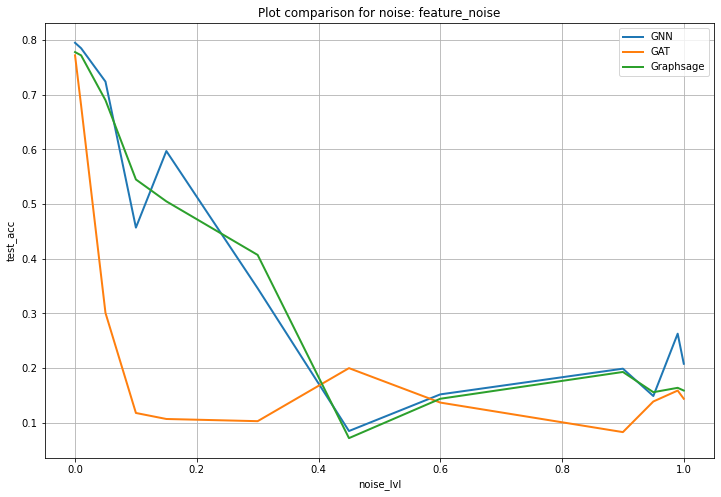

In [25]:
plot_comparison(data, 'feature_noise')

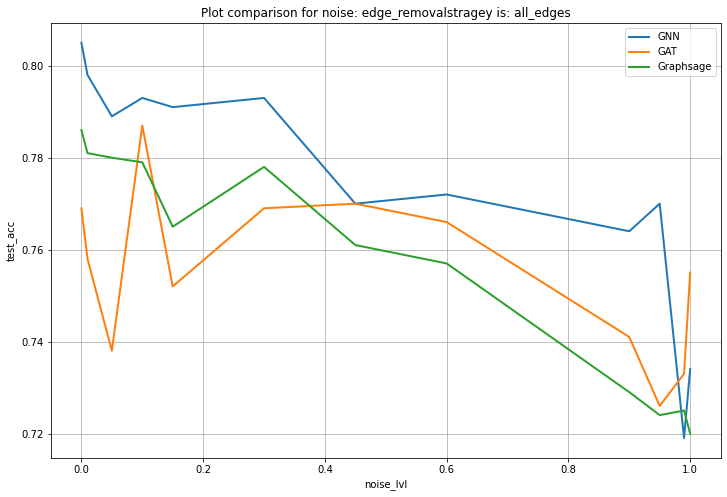

In [26]:
plot_comparison(data, 'edge_removal', 'all_edges')

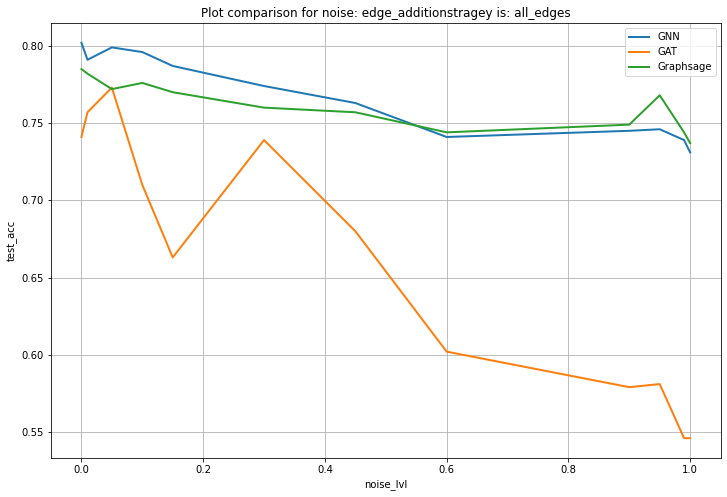

In [27]:
plot_comparison(data, 'edge_addition', 'all_edges')

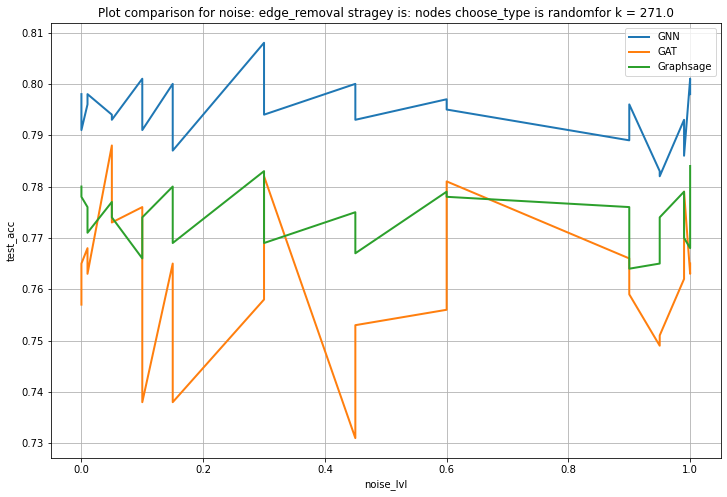

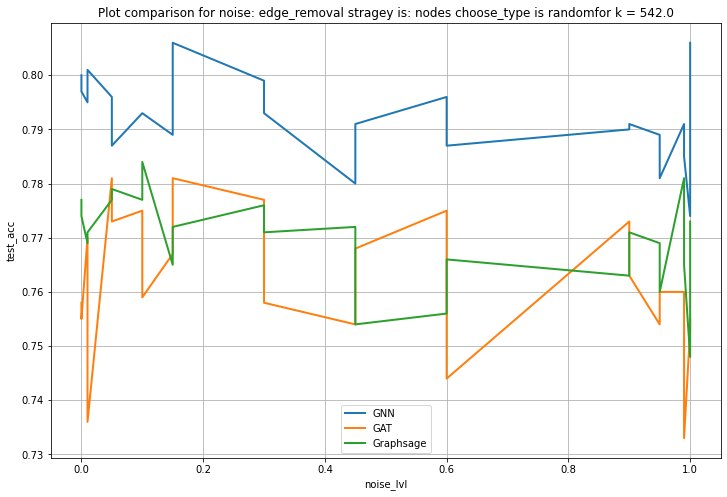

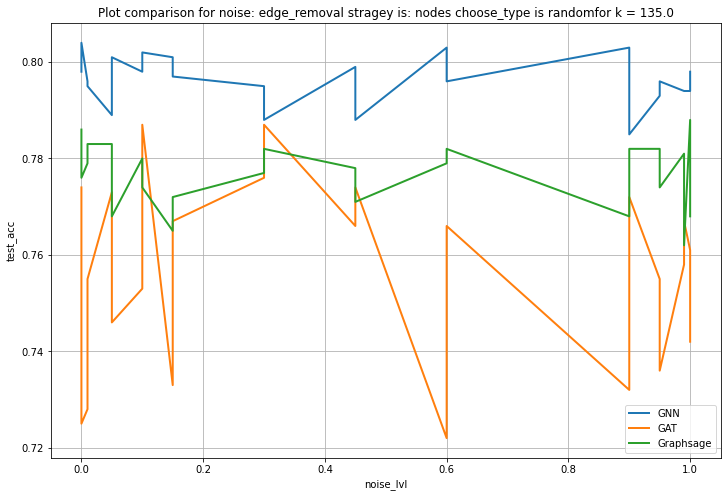

In [24]:
plot_comparison(data, 'edge_removal', 'nodes', 'random')